# TinyTimeMixer for Time Series Forecasting

# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

We will use a pre-trained TTM-1024-96 model. That means the TTM model can take an input of 1024 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.


Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](ibm-granite/granite-timeseries-ttm-r1).

1. TTM-R1 pre-trained models can be found here: [TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
    1. For 512-96 model set `TTM_MODEL_REVISION="main"`
    2. For 1024-96 model set `TTM_MODEL_REVISION="1024_96_v1"`
2. TTM-R2 pre-trained models can be found here: [TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
    1. For 512-96 model set `TTM_MODEL_REVISION="main"`
    2. For 1024-96 model set `TTM_MODEL_REVISION="1024-96-r2"`
    3. For 1536-96 model set `TTM_MODEL_REVISION="1536-96-r2"`

Details about the revisions (R1 and R2) can be found [here](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

## Environment Setup - Installation

In [ ]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.18"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.18) to /tmp/pip-install-r1isq1dg/tsfm-public_e5f2f4bb218943529c7d03138b54b8e7
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-r1isq1dg/tsfm-public_e5f2f4bb218943529c7d03138b54b8e7
  Running command git checkout -q 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Environment Setup - Imports

In [ ]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

## Environment Setup - Important Arguments


In [ ]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here etth1) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "ettm2"
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Forecasting parameters
# context_length =
# forecast_length =
context_length = 1024      # TTM-1024-96 -> model expects 1024 past points
forecast_length = 96       # ...and predicts 96 future points
fewshot_fraction = 0.05

# ----- TTM model path -----
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"


# ----- TTM model branch -----
# For R2 models
TTM_MODEL_REVISION="1024-96-r2"

## Data Processing Pipeline

**Note:** Here we use the TimeSeriesPreprocessor (TSP) module for data preparation. For standard datasets, TSP can quickly prepare the dataloaders using YAML files defined [here](https://github.com/ibm-granite/granite-tsfm/tree/main/tsfm_public/resources/data_config). Refer to the [TTM Getting Started](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/ttm_getting_started.ipynb) for example usage. Similar YAML file can be written for any new dataset as well.


In [ ]:
# Load the data file and see the columns
data = pd.read_csv(DATA_ROOT_PATH, parse_dates=["date"])

print("Columns:", data.columns.tolist())


Columns: ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


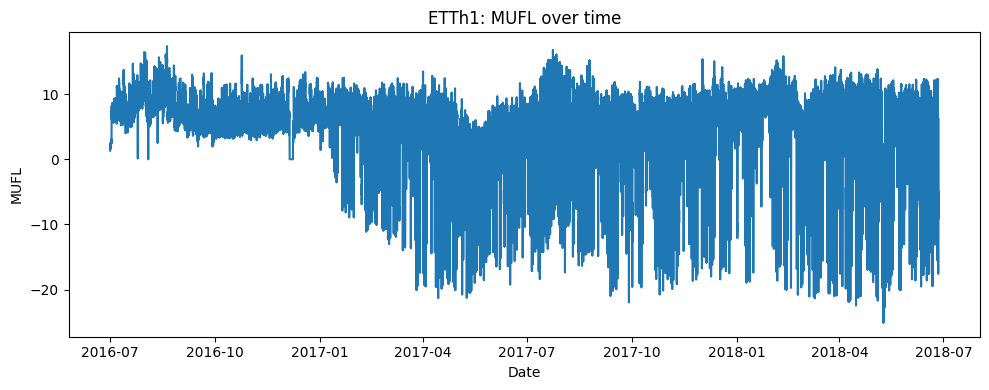

In [ ]:
# Plot date vs "MUFL"
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(data["date"], data["MUFL"])
plt.xlabel("Date")
plt.ylabel("MUFL")
plt.title("ETTh1: MUFL over time")
plt.tight_layout()
plt.show()


In [ ]:
dataset_path = DATA_ROOT_PATH
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 12 * 30 * 24],
    "valid": [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24],
    "test": [
        12 * 30 * 24 + 4 * 30 * 24,
        12 * 30 * 24 + 8 * 30 * 24,
    ],
}

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Obtain the train_dataset, valid_dataset, test_dataset using tsp get_dataset() by specifying the right arguments
train_dataset, valid_dataset, test_dataset = get_datasets(tsp, data, split_config)

# Print the length of train_dataset, valid_dataset, test_dataset
print("Train dataset length:", len(train_dataset))
print("Valid dataset length:", len(valid_dataset))
print("Test dataset length:", len(test_dataset))

Train dataset length: 7521
Valid dataset length: 2785
Test dataset length: 2785


In [ ]:
train_dataset[3]

{'past_values': tensor([[-0.4899, -0.0378, -0.6887,  ...,  1.0017,  0.7784,  0.8626],
         [-0.4438, -0.0378, -0.6501,  ...,  1.0613,  0.7784,  0.5252],
         [-0.3977,  0.0584, -0.6436,  ...,  1.2401,  0.9243,  0.4409],
         ...,
         [ 0.8122,  1.3726,  0.6442,  ...,  1.2108,  0.9243,  1.9895],
         [ 0.8468,  1.4683,  0.6056,  ...,  1.3886,  1.0211,  1.8822],
         [ 0.6509,  1.4683,  0.4317,  ...,  1.3886,  1.1163,  1.8132]]),
 'future_values': tensor([[0.7661, 1.3726, 0.5411, 1.1990, 1.5078, 0.7784, 1.6139],
         [1.7342, 0.9880, 1.1914, 0.5351, 3.5312, 0.9719, 1.5755],
         [1.6996, 0.7315, 1.1079, 0.0554, 3.4130, 1.0687, 1.5525],
         [2.3218, 2.3659, 1.9126, 1.9185, 2.7877, 0.8275, 1.5678],
         [2.0567, 1.8209, 1.7388, 1.2914, 2.2220, 0.8275, 1.5372],
         [2.2412, 1.8851, 1.7388, 1.2359, 3.7100, 1.4067, 1.5678],
         [2.2066, 2.1736, 1.6551, 1.1990, 3.5019, 1.3591, 1.4835],
         [1.7687, 1.2765, 1.3139, 0.7562, 3.0261, 1.2131,

## Zero-Shot Evaluation Method

In [ ]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)
zeroshot_model

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=128, out_features=384, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
             

In [ ]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        seed=SEED,
    ),
)

In [ ]:
# Perform zero-shot evaluation using the pre-trained model on the test dataset
print("+" * 20, "Zero-shot evaluation on test dataset", "+" * 20)
zeroshot_output = zeroshot_trainer.evaluate(test_dataset)

print(zeroshot_output)

zeroshot_eval_error = zeroshot_output.get("eval_loss", None)
print("Zero-shot evaluation error (eval_loss):", zeroshot_eval_error)


++++++++++++++++++++ Zero-shot evaluation on test dataset ++++++++++++++++++++


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zubair-atha (zubair-atha-columbia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.35859495401382446, 'eval_model_preparation_time': 0.0025, 'eval_runtime': 2.9534, 'eval_samples_per_second': 942.985, 'eval_steps_per_second': 14.898}
Zero-shot evaluation error (eval_loss): 0.35859495401382446


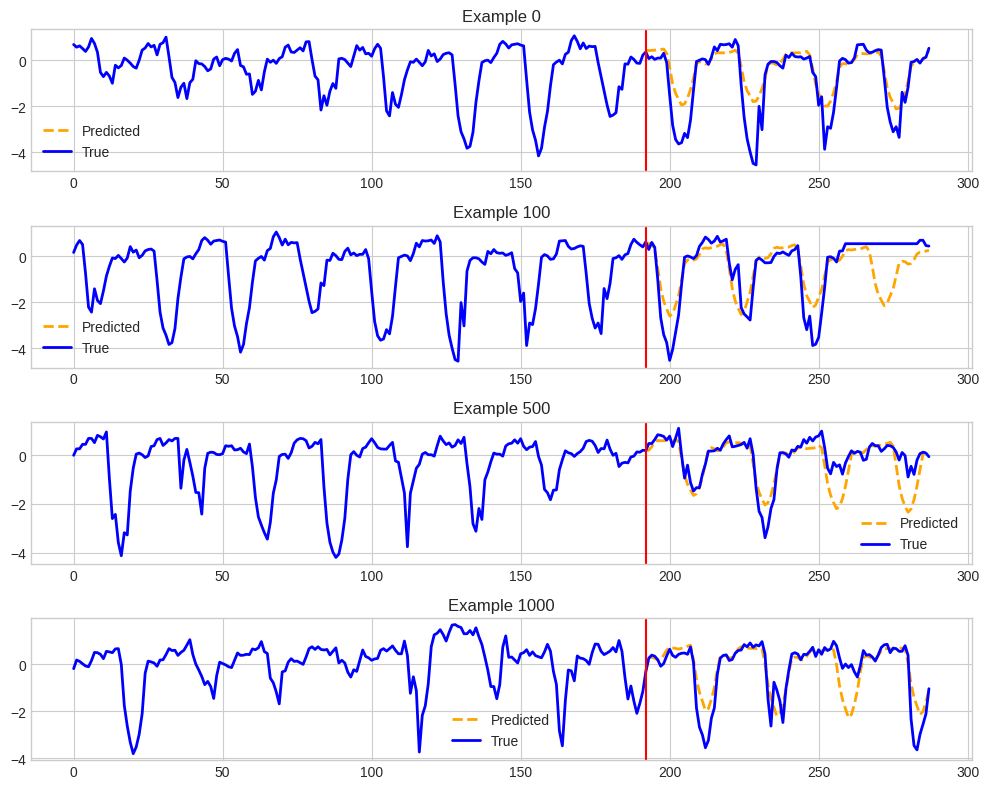

In [ ]:
# Plot the zero-shot predictions
import os

plot_dir = os.path.join(OUT_DIR, target_dataset, "zeroshot_plots")
os.makedirs(plot_dir, exist_ok=True)

plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=plot_dir,
    plot_prefix="test_zeroshot",
    # a few example indices inside the test set length (2785)
    indices=[0, 100, 500, 1000],
    channel=0,  # e.g., plot the first target channel (HUFL)
)


## Zero-Shot Evaluation with Truncated Forecast Length

In [ ]:
# Forecast 24 hrs in the future using the TTM-1024-96 model

# Load the same TTM model but truncate its usable prediction length to 24
zeroshot_24_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH,
    revision=TTM_MODEL_REVISION,
    prediction_filter_length=24,  # keep only the first 24 of the 96 forecast steps
)

temp_dir_24 = tempfile.mkdtemp()

zeroshot_24_trainer = Trainer(
    model=zeroshot_24_model,
    args=TrainingArguments(
        output_dir=temp_dir_24,
        per_device_eval_batch_size=64,
        seed=SEED,
    ),
)

print("+" * 20, "Zero-shot evaluation with prediction_filter_length=24", "+" * 20)
zeroshot_24_output = zeroshot_24_trainer.evaluate(test_dataset)

print(zeroshot_24_output)

zeroshot_24_eval_error = zeroshot_24_output.get("eval_loss", None)
print("Zero-shot (24-step) evaluation error (eval_loss):", zeroshot_24_eval_error)


++++++++++++++++++++ Zero-shot evaluation with prediction_filter_length=24 ++++++++++++++++++++


{'eval_loss': 0.3073784112930298, 'eval_model_preparation_time': 0.0022, 'eval_runtime': 1.3728, 'eval_samples_per_second': 2028.687, 'eval_steps_per_second': 32.051}
Zero-shot (24-step) evaluation error (eval_loss): 0.3073784112930298


* When we restrict the forecast to 24 steps instead of 96, the zero-shot error drops from ~0.359 to ~0.307, which makes sense because predicting closer in time is generally easier and more accurate than predicting further out.


## Few-Shot Fine-Tuning and Evaluation Method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [ ]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, head_dropout=0.7
)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=128, out_features=384, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
             

### Freeze the TTM backbone

In [ ]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)


Number of params before freezing backbone 2964960
Number of params after freezing the backbone 955424


### Finetune few-shot 5%

In [ ]:
# Important parameters
learning_rate = 0.001
num_epochs = 1  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

In [ ]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    seed=SEED,
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.427700,0.692788


[TrackingCallback] Mean Epoch Time = 4.738999605178833 seconds, Total Train Time = 6.00491189956665


TrainOutput(global_step=118, training_loss=0.427730269351248, metrics={'train_runtime': 6.0192, 'train_samples_per_second': 1249.509, 'train_steps_per_second': 19.604, 'total_flos': 959055354593280.0, 'train_loss': 0.427730269351248, 'epoch': 1.0})

In [ ]:
# Evaluate the fine-tuned model
print("+" * 20, "Few-shot 5%: evaluation on test dataset", "+" * 20)
fewshot_5_output = finetune_forecast_trainer.evaluate(test_dataset)
print(fewshot_5_output)

fewshot_5_eval_error = fewshot_5_output.get("eval_loss", None)
print("Few-shot 5% evaluation error (eval_loss):", fewshot_5_eval_error)


++++++++++++++++++++ Few-shot 5%: evaluation on test dataset ++++++++++++++++++++


{'eval_loss': 0.3612917363643646, 'eval_runtime': 1.247, 'eval_samples_per_second': 2233.437, 'eval_steps_per_second': 35.286, 'epoch': 1.0}
Few-shot 5% evaluation error (eval_loss): 0.3612917363643646


### Finetune few-shot 10%

In [ ]:
from torch.utils.data import Subset
import numpy as np

# Few-shot fraction 10%
fewshot_fraction_10 = 0.10

# Create 10% few-shot train and valid datasets
n_train_all = len(train_dataset)
train_idx_10 = np.random.permutation(n_train_all)[: int(fewshot_fraction_10 * n_train_all)]
train_dataset_10 = Subset(train_dataset, train_idx_10)

n_valid_all = len(valid_dataset)
valid_idx_10 = np.random.permutation(n_valid_all)[: int(fewshot_fraction_10 * n_valid_all)]
valid_dataset_10 = Subset(valid_dataset, valid_idx_10)

print("Train few-shot 10% length:", len(train_dataset_10))
print("Valid few-shot 10% length:", len(valid_dataset_10))

# Load a fresh model for 10% few-shot fine-tuning
finetune_forecast_model_10 = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, head_dropout=0.7
)

# Freeze the backbone of the model
for param in finetune_forecast_model_10.backbone.parameters():
    param.requires_grad = False

# Use same hyperparameters as before
finetune_forecast_args_10 = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output_10pct"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs_10pct"),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=SEED,
)

optimizer_10 = AdamW(finetune_forecast_model_10.parameters(), lr=learning_rate)
scheduler_10 = OneCycleLR(
    optimizer_10,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset_10) / batch_size),
)

finetune_forecast_trainer_10 = Trainer(
    model=finetune_forecast_model_10,
    args=finetune_forecast_args_10,
    train_dataset=train_dataset_10,
    eval_dataset=valid_dataset_10,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer_10, scheduler_10),
)

# Fine-tune with 10% data
finetune_forecast_trainer_10.train()

# Evaluate on test dataset
print("+" * 20, "Few-shot 10%: evaluation on test dataset", "+" * 20)
fewshot_10_output = finetune_forecast_trainer_10.evaluate(test_dataset)
print(fewshot_10_output)

fewshot_10_eval_error = fewshot_10_output.get("eval_loss", None)
print("Few-shot 10% evaluation error (eval_loss):", fewshot_10_eval_error)


Train few-shot 10% length: 752
Valid few-shot 10% length: 278


Epoch,Training Loss,Validation Loss
1,0.623400,0.681371


[TrackingCallback] Mean Epoch Time = 0.7771461009979248 seconds, Total Train Time = 1.1976935863494873
++++++++++++++++++++ Few-shot 10%: evaluation on test dataset ++++++++++++++++++++


{'eval_loss': 0.3667856454849243, 'eval_runtime': 1.1982, 'eval_samples_per_second': 2324.299, 'eval_steps_per_second': 36.721, 'epoch': 1.0}
Few-shot 10% evaluation error (eval_loss): 0.3667856454849243


* With only 1 epoch and a frozen backbone, few-shot fine-tuning (5% and 10%) doesn’t improve over zero-shot (0.3586) and in fact slightly worsens test loss (≈0.3613 for 5% and ≈0.3668 for 10%), suggesting the head may be overfitting the small subsets or not trained long enough.
* The 10% few-shot run performing slightly worse than the 5% run hints that “more data” isn’t automatically better under this shallow training setup; better tuning (more epochs, different LR, or unfreezing more layers) might be needed to see real gains.


## Few-Shot Evaluation with Different Loss Function

This section demonstrates few-shot fine-tuning using Mean Absolute Error (MAE) instead of the default loss function. We use 5% of the training data, freeze the backbone, and fine-tune for 1 epoch.

In [ ]:
from torch.utils.data import Subset
import numpy as np

# ----- Create 5% few-shot train and valid datasets -----
fewshot_fraction_5 = 0.05

n_train_all = len(train_dataset)
train_idx_5 = np.random.permutation(n_train_all)[: int(fewshot_fraction_5 * n_train_all)]
train_dataset_5 = Subset(train_dataset, train_idx_5)

n_valid_all = len(valid_dataset)
valid_idx_5 = np.random.permutation(n_valid_all)[: int(fewshot_fraction_5 * n_valid_all)]
valid_dataset_5 = Subset(valid_dataset, valid_idx_5)

print("Train few-shot 5% length:", len(train_dataset_5))
print("Valid few-shot 5% length:", len(valid_dataset_5))

# ----- Load a fresh model and switch loss to MAE -----
finetune_mae_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH,
    revision=TTM_MODEL_REVISION,
    head_dropout=0.7,
)

# Change the loss function to MAE
finetune_mae_model.config.loss = "mae"

# ----- Freeze the backbone -----
for param in finetune_mae_model.backbone.parameters():
    param.requires_grad = False

# ----- Training arguments (same hyperparams as before) -----
finetune_mae_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output_5pct_mae"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,  # 1 epoch
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs_5pct_mae"),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=SEED,
)

optimizer_mae = AdamW(finetune_mae_model.parameters(), lr=learning_rate)
scheduler_mae = OneCycleLR(
    optimizer_mae,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset_5) / batch_size),
)

finetune_mae_trainer = Trainer(
    model=finetune_mae_model,
    args=finetune_mae_args,
    train_dataset=train_dataset_5,
    eval_dataset=valid_dataset_5,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer_mae, scheduler_mae),
)

# ----- Fine-tune with MAE loss on 5% data -----
finetune_mae_trainer.train()

# ----- Evaluate on test dataset -----
print("+" * 20, "Few-shot 5% with MAE loss: evaluation on test dataset", "+" * 20)
fewshot_5_mae_output = finetune_mae_trainer.evaluate(test_dataset)
print(fewshot_5_mae_output)

fewshot_5_mae_eval_error = fewshot_5_mae_output.get("eval_loss", None)
print("Few-shot 5% (MAE loss) evaluation error (eval_loss):", fewshot_5_mae_eval_error)


Train few-shot 5% length: 376
Valid few-shot 5% length: 139


Epoch,Training Loss,Validation Loss
1,0.809400,0.618028


[TrackingCallback] Mean Epoch Time = 0.5249078273773193 seconds, Total Train Time = 0.9060921669006348
++++++++++++++++++++ Few-shot 5% with MAE loss: evaluation on test dataset ++++++++++++++++++++


{'eval_loss': 0.36637648940086365, 'eval_runtime': 1.1819, 'eval_samples_per_second': 2356.37, 'eval_steps_per_second': 37.228, 'epoch': 1.0}
Few-shot 5% (MAE loss) evaluation error (eval_loss): 0.36637648940086365


* Switching the loss to MAE for 5% few-shot fine-tuning slightly worsens the test error (~0.3664) compared to both zero-shot (~0.3586) and 5% few-shot with the default loss (~0.3613), so in this shallow setup MAE doesn’t provide a benefit.
* The relatively high validation loss (≈0.618) after just 1 epoch again suggests that with a frozen backbone and tiny dataset, the head doesn’t adapt strongly, and the choice of loss alone isn’t enough to noticeably improve generalization.


## Zero-Shot Evaluation on Specific Channels

This section demonstrates how to forecast only specific channels (channels 0 and 2) by setting `prediction_channel_indices=[0,2]` during model loading.

```python
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, prediction_channel_indices=[0,2])
output = zeroshot_model.forward(test_dataset[0]['past_values'].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape
```

In [ ]:
import torch

# Load zero-shot model that only forecasts channels 0 and 2
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH,
    revision=TTM_MODEL_REVISION,
    prediction_channel_indices=[0, 2],
)

# Take the first example from the test dataset
sample_past_values = test_dataset[0]["past_values"].unsqueeze(0)  # add batch dimension

# Forward pass (zero-shot, no loss)
output = zeroshot_model.forward(sample_past_values, return_loss=False)

# Check the shape of the prediction outputs
print("prediction_outputs shape:", output.prediction_outputs.shape)


prediction_outputs shape: torch.Size([1, 96, 2])


* The output shape `[1, 96, 2]` shows that for a single sample (batch size 1), the model predicts 96 future time steps for exactly 2 channels, matching the forecast_length (96) and the chosen prediction_channel_indices `[0, 2]`.


## Summary

* **Data processing (ETTh1 + TSP)**

  * Loaded ETTh1 with columns: `['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']`.
  * Visualized `date` vs `MUFL` to see how one channel evolves over time.
  * Used `TimeSeriesPreprocessor` with:

    * `context_length = 1024`
    * `forecast_length = 96`
  * Created splits (via `split_config`) and got:

    * Train dataset length: **7521**
    * Valid dataset length: **2785**
    * Test dataset length: **2785**
  * *Observation:* The dataset is reasonably large, and the splits are consistent with the long-horizon forecasting setting (months of train, weeks of valid/test).

---

* **Zero-shot evaluation (full 96-step forecast)**

  * Loaded `TinyTimeMixerForPrediction` (`TTM-1024-96`, R2).
  * Ran zero-shot on the **test** dataset:

    * Zero-shot eval loss (96-step): **≈ 0.3586**
  * *Observation:* Without any fine-tuning on ETTh1, the pre-trained TTM already achieves a solid error, showing strong **out-of-the-box generalization**.

---

* **Zero-shot with truncated forecast length (24-step effective horizon)**

  * Reloaded TTM with `prediction_filter_length = 24` (still `TTM-1024-96` under the hood).
  * Evaluated again on the test set:

    * Zero-shot eval loss (24-step): **≈ 0.3074**
  * *Observation:* Restricting the forecast to the first **24 steps** improves loss compared to the full 96-step forecast (**0.3074 vs 0.3586**), which matches intuition: **shorter-term predictions are easier and more accurate** than long-horizon ones.

---

* **Freezing the backbone**

  * Parameter counts:

    * Before freezing backbone: **2,964,960** parameters trainable.
    * After freezing backbone: **955,424** trainable (only the head and related parts).
  * *Observation:* Freezing the backbone drastically reduces the number of parameters that can change, making fine-tuning cheaper and less risky, but also limiting how much the model can adapt to ETTh1.

---

* **Few-shot fine-tuning with 5% data (default loss, likely MSE)**

  * Used:

    * `fewshot_fraction = 0.05` on the training data.
    * `num_epochs = 1`, `batch_size = 64`, `learning_rate = 0.001`.
  * Results:

    * Train loss ≈ **0.4277**
    * Validation loss ≈ **0.6928**
    * Test eval loss: **≈ 0.3613**
  * *Observation:* After only 1 epoch with a frozen backbone, the **few-shot 5%** model performs **slightly worse** than pure zero-shot (0.3613 vs 0.3586), suggesting limited adaptation and possibly some over/under-fitting in the head.

---

* **Few-shot fine-tuning with 10% data (default loss)**

  * 10% few-shot subset:

    * Train few-shot length: **752**
    * Valid few-shot length: **278**
  * Training (1 epoch):

    * Train loss ≈ **0.6234**
    * Validation loss ≈ **0.6814**
    * Test eval loss: **≈ 0.3668**
  * *Observation:* Using **more data (10%) with the same shallow, 1-epoch, frozen-backbone setup** actually makes test performance slightly worse (0.3668 vs 0.3613 for 5%, and vs 0.3586 zero-shot). This hints that the combination of:

    * frozen backbone,
    * short training, and
    * current hyperparameters
      isn’t enough to leverage the extra data effectively.

---

* **Few-shot 5% with MAE loss**

  * Created a new 5% few-shot subset:

    * Train few-shot length: **376**
    * Valid few-shot length: **139**
  * Loaded a fresh TTM model, set `config.loss = "mae"`, froze backbone again.
  * Training (1 epoch):

    * Train loss ≈ **0.8094**
    * Validation loss ≈ **0.6180**
    * Test eval loss: **≈ 0.3664**
  * *Observation:* Changing the loss to **MAE** for this shallow few-shot setup **did not help**; test loss is slightly worse than both zero-shot and 5%-MSE fine-tune. The loss choice alone can’t compensate for limited training and a frozen backbone.

---

* **Channel-specific zero-shot: only channels 0 and 2**

  * Loaded TTM with `prediction_channel_indices = [0, 2]`.
  * Ran forward on a single test example:

    * `prediction_outputs` shape: **`[1, 96, 2]`**
  * *Observation:* This confirms the output structure:

    * batch size: `1`
    * forecast horizon: `96`
    * predicted channels: `2` (channels 0 and 2),
      showing how to **focus the model on only certain variables**.

---

* **Overall takeaways**

  * **Pre-trained TTM is strong zero-shot**: without any ETTh1 training, it gives a reasonably low error.
  * **Shorter horizon is easier**: truncating to a 24-step forecast clearly improves performance over the full 96-step forecast.
  * **Naive few-shot fine-tuning (frozen backbone + 1 epoch)**:

    * With 5% or 10% data, and default loss, does **not beat zero-shot** and can slightly degrade performance.
    * This suggests you’d likely need:

      * slightly more epochs,
      * possibly unfreezing some backbone layers,
      * or tuned learning rates to see real gains.
  * **Changing loss to MAE alone doesn’t save the day**:

    * In this setup, MAE-based fine-tuning performs marginally worse than MSE-based fine-tuning.
  * **Model flexibility**:

    * adjust effective forecast length (`prediction_filter_length`),
    * limit prediction to specific channels (`prediction_channel_indices`),
      which makes TTM flexible for different real-world forecasting needs.

